# Vision transformer fine-tuning

Turning ViT into a patch autoencoder.

In [ ]:
import os

import numpy as np
import torch
from PIL import Image
from torch import nn
from torchvision import transforms
from transformers import ViTConfig, ViTImageProcessor, ViTModel

# --- Config ---
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
IMAGE_DIR = "../images/iris"
MODEL_NAME = "google/vit-base-patch16-224"
EPOCHS = 5

# --- Load data ---
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith((".jpg", ".png"))])  # noqa: PTH208
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

images = []
pil_images = []

for fname in image_files:
    path = os.path.join(IMAGE_DIR, fname)  # noqa: PTH118
    img = Image.open(path).convert("RGB")
    pil_images.append(img.resize((224, 224)))  # for patch vis
    images.append(transform(img))

images = torch.stack(images).to(DEVICE)

# --- Load ViT and processor ---
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
config = ViTConfig.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True  # make sure we can fine-tune

# Linear head for patch embeddings
head = nn.Linear(config.hidden_size, 3 * 16 * 16).to(DEVICE)
optimizer = torch.optim.AdamW(list(model.parameters()) + list(head.parameters()), lr=5e-5)
loss_fn = nn.SmoothL1Loss()


# Extract patch embeddings
def get_patch_embeddings(image_batch):
    model.eval()
    inputs = processor(images=image_batch, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 1:, :].cpu().numpy()  # (1, 196, 768)


def get_positional_embeddings(model):
    with torch.no_grad():
        pos_embed = model.embeddings.position_embeddings[0, 1:, :]  # skip [CLS] token
        return pos_embed.cpu().numpy()  # (196, 768)


# --- Store embedding snapshots ---
embedding_history = [get_patch_embeddings([pil_images[0]])[0]]
pos_embedding_history = [get_positional_embeddings(model)]

# Fine-tune the model
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for img in images:
        img = img.unsqueeze(0)  # (1, 3, 224, 224)
        inputs = processor(images=img, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # (1, 196, 768)

        preds = head(patch_tokens)  # (1, 196, 768)
        # Targets (RGB patches from original image)
        patches = img.squeeze(0).unfold(1, 16, 16).unfold(2, 16, 16)  # (3, 14, 14, 16, 16)
        patches = patches.permute(1, 2, 0, 3, 4).reshape(-1, 3 * 16 * 16).to(DEVICE)  # (196, 768)
        loss = loss_fn(preds.squeeze(0), patches)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss:.4f}")

    emb = get_patch_embeddings([pil_images[0]])[0]
    embedding_history.append(emb)
    pos_embedding_history.append(get_positional_embeddings(model))

    # --- Compare token 100 before/after ---
    delta = np.linalg.norm(embedding_history[-1][100] - embedding_history[-2][100])
    print(f"Embedding change for patch 100: {delta:.6f}")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 1.5759
Embedding change for patch 100: 3.628897
Epoch 2/5, Loss: 0.7860
Embedding change for patch 100: 2.346775
Epoch 3/5, Loss: 0.4210
Embedding change for patch 100: 1.725208
Epoch 4/5, Loss: 0.3544
Embedding change for patch 100: 0.836804
Epoch 5/5, Loss: 0.3434
Embedding change for patch 100: 0.512082


## Patch embeddings

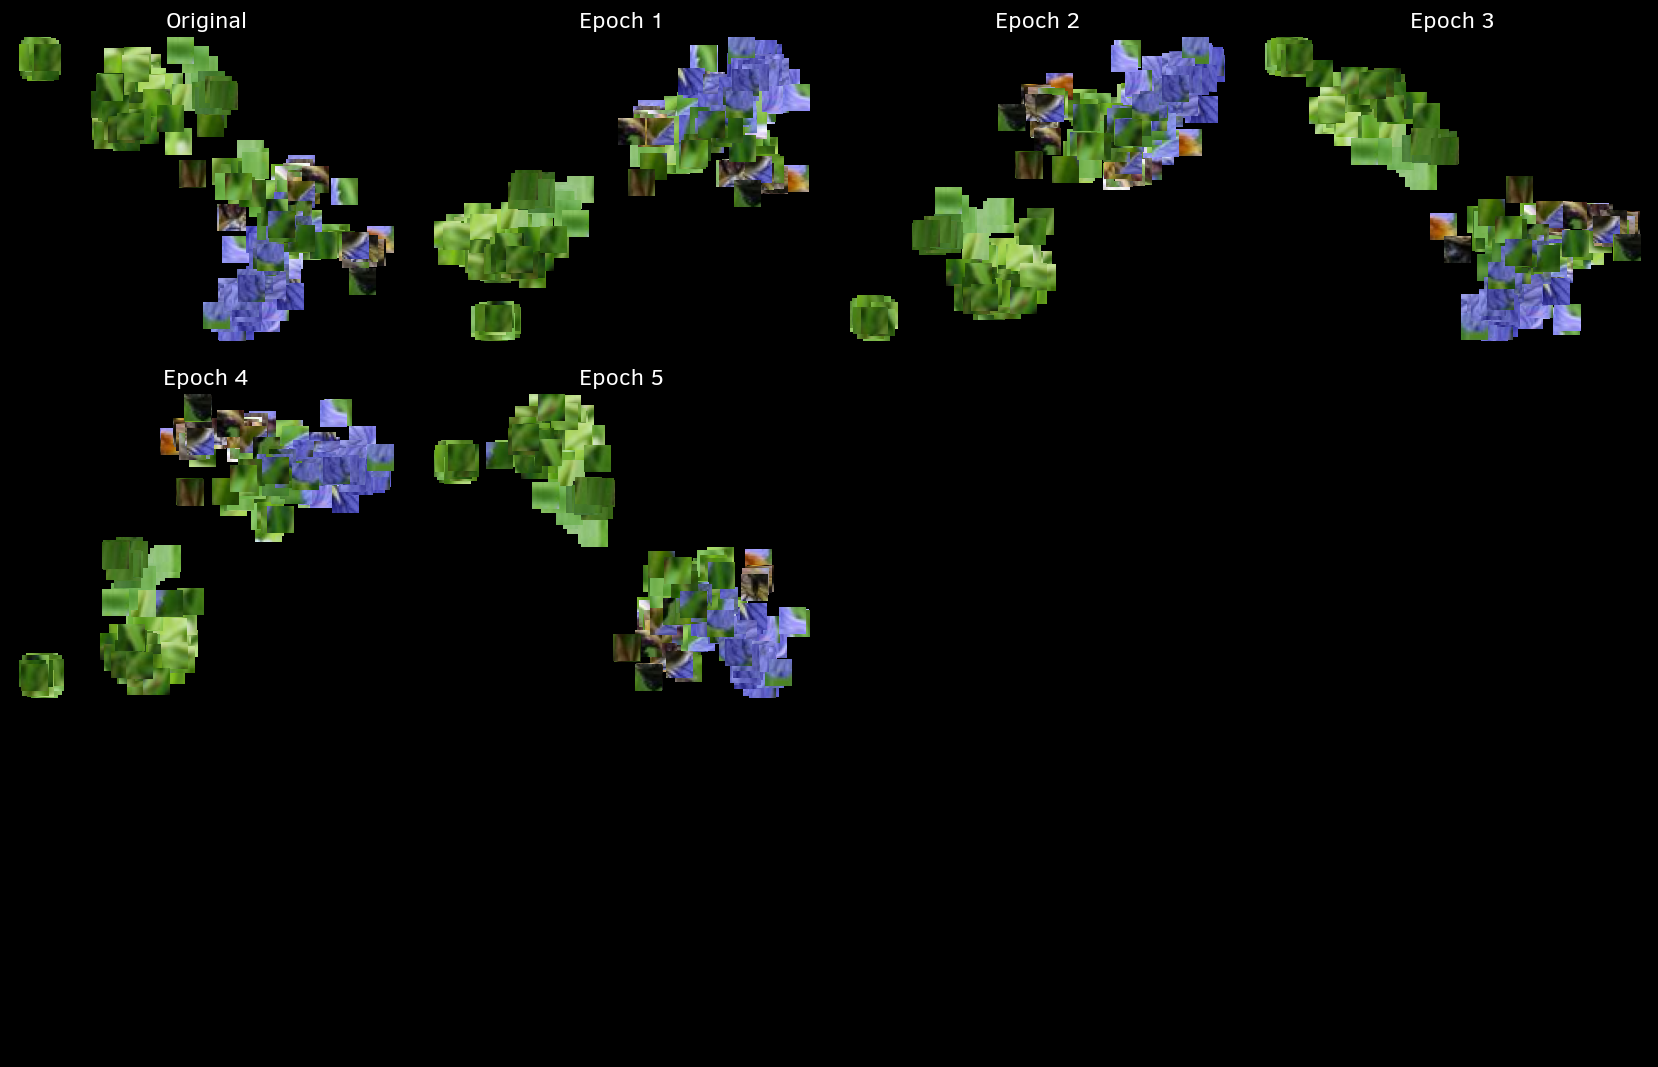

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import TSNE

plt.style.use("dark_background")
plt.rcParams["font.family"] = "Clear Sans"


coords = [(i // 14, i % 14) for i in range(196)]
patch_size = 16
image_resized = pil_images[0]

# Grid of patches
rows, cols = 3, 4  # Enough for 11 plots (original + 10 epochs)
fig, axes = plt.subplots(rows, cols, figsize=(14, 9), dpi=120)
axes = axes.flatten()

for i, emb in enumerate(embedding_history):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    proj = tsne.fit_transform(emb)

    # Normalize to [-1, 1]
    proj = (proj - proj.min(0)) / (proj.max(0) - proj.min(0))  # [0, 1]
    proj = proj * 2 - 1  # [-1, 1]

    ax = axes[i]
    ax.set_title(f"Epoch {i}" if i > 0 else "Original", fontsize=14)

    ax.scatter(proj[:, 0], proj[:, 1], alpha=0)

    for j, (x, y) in enumerate(proj):
        row, col = j // 14, j % 14
        patch = image_resized.crop(
            (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
        )
        ab = AnnotationBbox(OffsetImage(patch, zoom=1.0), (x, y), frameon=False)
        ax.add_artist(ab)

    ax.axis("off")

# Hide extra subplots
for j in range(len(embedding_history), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Positional Embeddings

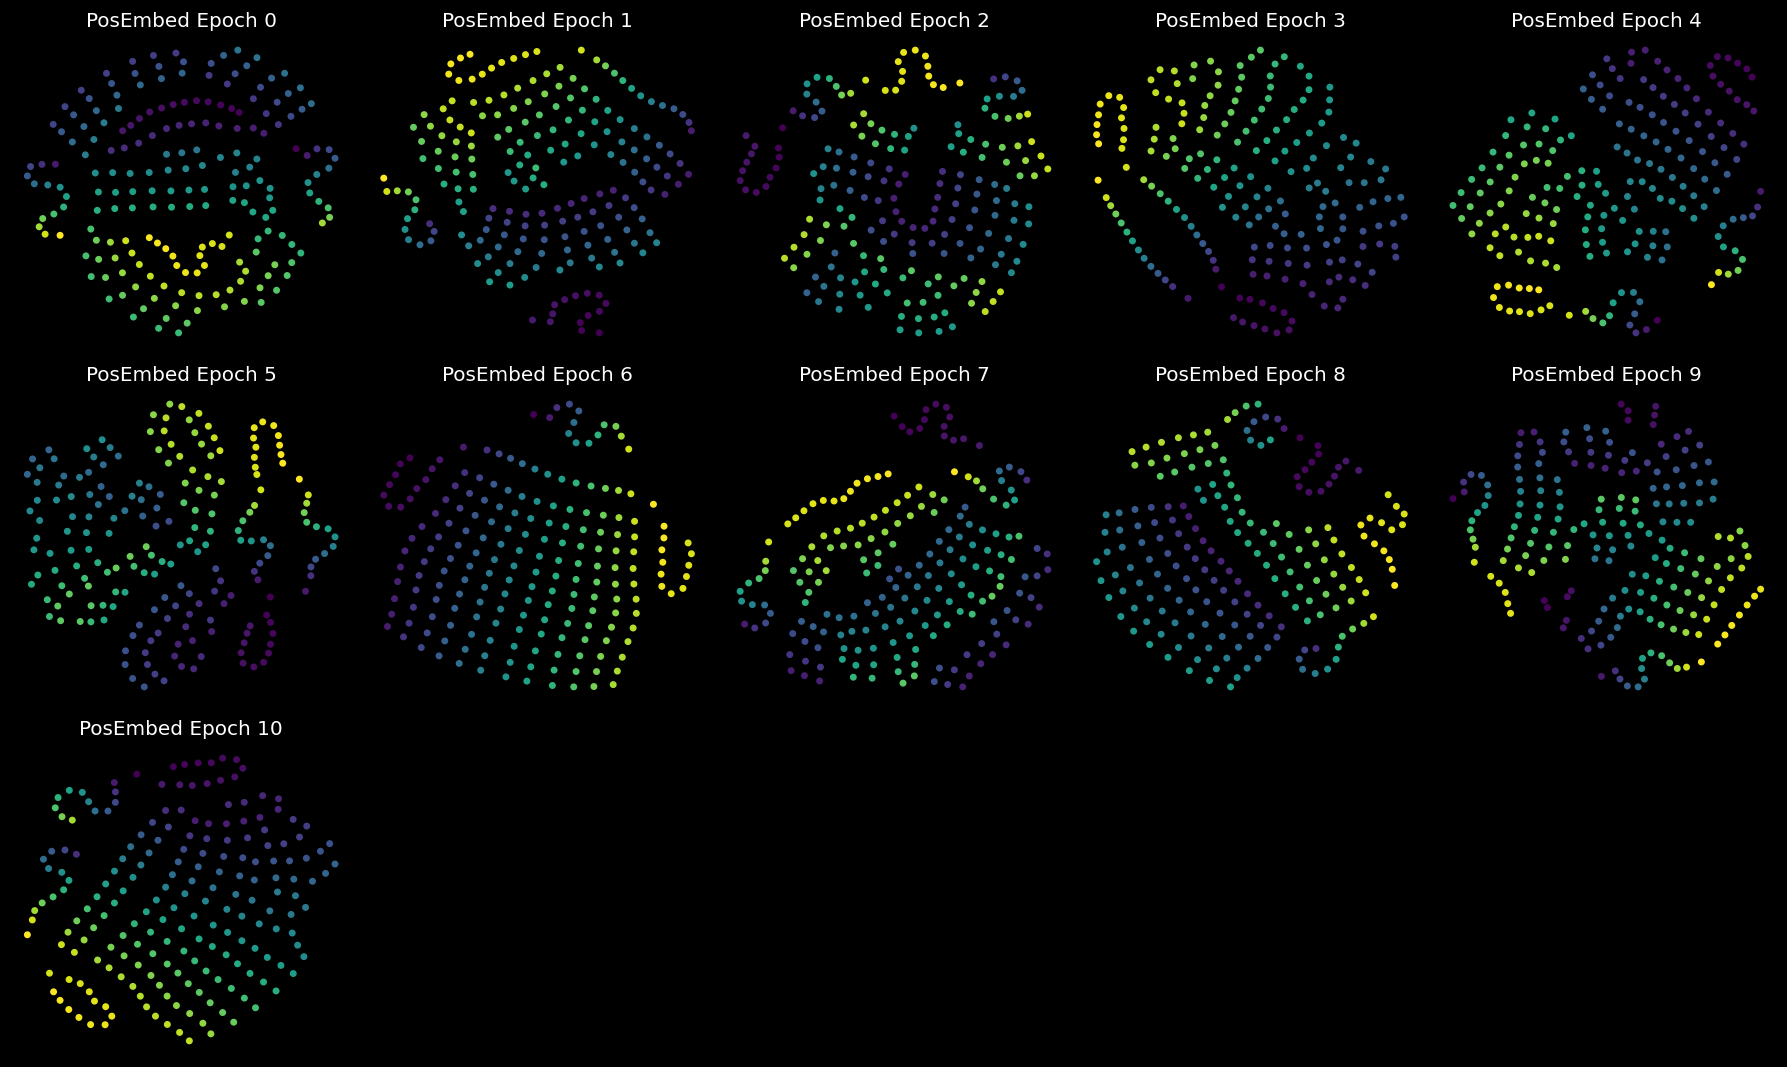

In [ ]:
import math

n = len(pos_embedding_history)  # should be EPOCHS + 1
cols = 5
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), dpi=120)
axes = axes.flatten()

for i, pos in enumerate(pos_embedding_history):
    proj = TSNE(n_components=2, perplexity=30, learning_rate=100, random_state=42).fit_transform(
        pos
    )
    axes[i].scatter(proj[:, 0], proj[:, 1], c=np.arange(196), cmap="viridis", s=10)
    axes[i].set_title(f"PosEmbed Epoch {i}")
    axes[i].axis("off")

# Hide any extra unused subplots
for i in range(n, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()